# Parameter-Efficient Fine Tuning with LoRA

Instead of completely retraining a model with millions or billions of parameters on the specific task data, one can freeze all the model weights and replace a subset of them with a much smaller number of trainable weights. Good performance, relative to a fully trained model, is achieved by clever use of rank decomposition of a matrix, whereby we have two low-rank matrices that when multiplied together yield the same number of weights that were replaced. The important assumption is that, for downstream tasks, only a small subset of these parameters are important for performance. This makes sense given that large LLMs learn a variety of general features of language from their training corpus, while a task like sentiment analysis only requires using a fraction of those features. So, to summarize, we are approximating weight matrices with pairs of low-rank matrices while maintaining decent performance and significantly improving training speed.

In [23]:
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import warnings

from datasets import load_dataset, DatasetDict, Dataset
from huggingface_hub import login
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

warnings.simplefilter('ignore', UserWarning)

# Model: distilbert-base-uncased

url: https://huggingface.co/distilbert/distilbert-base-uncased

paper: https://arxiv.org/abs/1910.01108

Trained for Masked Language Modeling (MLM) and encodes a bidirectonal representation of input sequences like BERT. Achieves similar performance to BERT but with 40% less parameters. DistilBERT loss function also trains for outputting the probabilities of the original BERT and having the same hidden states.

# Dataset: zeroshot/twitter-financial-news-sentiment

url: https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment

Sequences are financial news tweets. Each sequence is labeled 0, 1, 2 corresponding to "bearish," "bullish," and "neutral" respectively. Model performance before and after training is compared.

In [2]:
device = 'cuda'
model_name = 'distilbert-base-uncased'
dataset_path = 'zeroshot/twitter-financial-news-sentiment'

dataset = load_dataset(dataset_path)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})


In [3]:
METRICS = ['accuracy', 'recall', 'precision', 'f1']
model_performance = {}
model_performance['untuned'] = {}
model_performance['untuned']['train'] = {}
model_performance['untuned']['val'] = {}

model_performance['tuned'] = {}
model_performance['tuned']['epochs_1'] = {}
model_performance['tuned']['epochs_1']['train'] = {}
model_performance['tuned']['epochs_1']['val'] = {}

model_performance['tuned']['epochs_5'] = {}
model_performance['tuned']['epochs_5']['train'] = {}
model_performance['tuned']['epochs_5']['val'] = {}

In [4]:
n_training = dataset['train'].num_rows
n_val = dataset['validation'].num_rows
class_labels = [0, 1, 2]

print(f'Training ({n_training} rows)')
for class_label in class_labels:
    class_label_count = np.sum(np.array(dataset['train']['label']) == class_label)
    print(f'\t{class_label}: {np.round((class_label_count/n_training)*100, 1)}%')

print(f'\nValidation ({n_val} rows)')
for class_label in class_labels:
    class_label_count = np.sum(np.array(dataset['validation']['label']) == class_label)
    print(f'\t{class_label}: {np.round((class_label_count/n_val)*100, 1)}%')

Training (9543 rows)
	0: 15.1%
	1: 20.2%
	2: 64.7%

Validation (2388 rows)
	0: 14.5%
	1: 19.9%
	2: 65.6%


# Load the pretrained distilbert-base-uncased model and provide the API a class label mapping.

Base model has embedding, transformers (6), and fully-connected blocks.

In [5]:
id2label = {
    0: "Bearish", 
    1: "Bullish",
    2: "Neutral"
}

label2id = {}
for k in id2label.keys():
    label2id[id2label[k]] = k

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(id2label.keys()), id2label=id2label, label2id=label2id
)

model.to(device)
print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# Light preprocessing to make sequence lengths uniform. Using a data collator will minimize the number of padding tokens required by batching sequences logically.

In [6]:
def tokenize_function(samples):
    tokenizer.truncation_side = "left"
    return tokenizer(samples["text"], return_tensors="np", truncation=True, max_length=512)

def get_accuracy(probabilities):
    predictions, labels = probabilities
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return {"accuracy": acc}

# returns a dictionary with keys for accuracy, recall, precision, and f1
def evaluate_model(model, predictions, references):
    metric_dict = {}
    for metric in METRICS:
        evaluator = evaluate.load(metric)
        if metric != 'accuracy':
            metric_dict[metric] = evaluator.compute(predictions=predictions, references=references, average="weighted")[metric]
        else:
            metric_dict[metric] = evaluator.compute(predictions=predictions, references=references)[metric]
        metric_dict[metric] = round(metric_dict[metric], 4)
    return metric_dict



tokenizer = AutoTokenizer.from_pretrained(model_name, add_prefix_space=True)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenized_dataset = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy");

# Untuned performance

In [7]:
examples = [
    "Dropbox on watch after stinging Spruce Point report.",                                                              
    "Disney downgraded as analyst says parks attendance could take 2 years to 'normalize' https://t.co/InJKourtW3.",     
    "Freeport upgraded as Credit Suisse sees big buying opportunity https://t.co/d4TGqrNi7Y.",                           
    "MKM Partners puts a number on Victoria's Secret",                                                                   
    "TJX Q3 FactSet consensus 66 cents",                                                                                 
    "The Fed may lower the rate on its support facility for money market funds, strategists say https://t.co/FrLrivydji" 
]

print('Example predictions before fine-tuning:\n')
for example in examples:
    inputs = tokenizer.encode(example, return_tensors="pt").to(device)
    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    snippet = f'{example[:60]} ... '.ljust(65, ' ') + ':'
    print(f'{snippet:75} {id2label[predictions.tolist()]}')

Example predictions before fine-tuning:

Dropbox on watch after stinging Spruce Point report. ...         :          Bearish
Disney downgraded as analyst says parks attendance could tak ... :          Bearish
Freeport upgraded as Credit Suisse sees big buying opportuni ... :          Bearish
MKM Partners puts a number on Victoria's Secret ...              :          Bearish
TJX Q3 FactSet consensus 66 cents ...                            :          Bearish
The Fed may lower the rate on its support facility for money ... :          Bearish


In [8]:
x_train = dataset['train']['text']
y_train = dataset['train']['label']
x_val = dataset['validation']['text']
y_val = dataset['validation']['label']

predictions = []
for x in x_train:
    inputs = tokenizer.encode(x, return_tensors="pt").to(device)
    logits = model(inputs).logits
    prediction = int(torch.argmax(logits))
    predictions.append(prediction)

model_performance['untuned']['train'] = evaluate_model(model, predictions, y_train)
print(f'train: {model_performance['untuned']['train']}')

predictions = []
for x in x_val:
    inputs = tokenizer.encode(x, return_tensors="pt").to(device)
    logits = model(inputs).logits
    prediction = int(torch.argmax(logits))
    predictions.append(prediction)

model_performance['untuned']['val'] = evaluate_model(model, predictions, y_val)
print(f'validation: {model_performance['untuned']['val']}')

train: {'accuracy': 0.1676, 'recall': 0.1676, 'precision': 0.5662, 'f1': 0.0929}
validation: {'accuracy': 0.1499, 'recall': 0.1499, 'precision': 0.5835, 'f1': 0.0799}


# PEFT parameters

In [9]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",        # Specifies a Text classification task
    r=4,                        # Rank of the matrix of trainable weights (a higher rank means more trainable parameters)
    lora_alpha=32,              # Alpha parameter of lora scaling
    lora_dropout=0.01,          # Dropout probability of the lora layer
    target_modules = ['q_lin']  # The names of the modules in the original model to replace with the lora layer
)
print(peft_config)

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None)


In [10]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model.to(device)

trainable params: 629,763 || all params: 67,585,542 || trainable%: 0.9318013607111414


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): MultiHeadSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.01, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=76

# Training hyperparmeters

In [11]:
lr = 1e-3
batch_size = 4
n_epochs = 1
strategy = 'epoch'
reg_strength = 0.01

output_dir = f'./{model_name}-sentiment-analysis'

# encapsulate our hyperparameters with a TrainingArguments object
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=n_epochs,
    weight_decay=reg_strength,
    evaluation_strategy=strategy,
    save_strategy=strategy,
    load_best_model_at_end=True,
)

# everything we need to train and evaluate the model will be encapsulated by this Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=get_accuracy,
)

training_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.526600,0.429581,{'accuracy': 0.8467336683417085}


# After fine-tuning

In [12]:
print('Example predictions after fine-tuning:\n')
for example in examples:
    inputs = tokenizer.encode(example, return_tensors="pt").to(device)
    logits = model(inputs).logits
    predictions = torch.argmax(logits)
    snippet = f'{example[:40]} ... '.ljust(45, ' ') + ':'
    print(f'{snippet:50} {id2label[predictions.tolist()]}')

Example predictions after fine-tuning:

Dropbox on watch after stinging Spruce P ... :     Neutral
Disney downgraded as analyst says parks  ... :     Bearish
Freeport upgraded as Credit Suisse sees  ... :     Bullish
MKM Partners puts a number on Victoria's ... :     Neutral
TJX Q3 FactSet consensus 66 cents ...        :     Neutral
The Fed may lower the rate on its suppor ... :     Neutral


# Performance increases dramatically after a single epoch of training and no hyperparameter tuning.

In [13]:
predictions = []
for x in x_train:
    inputs = tokenizer.encode(x, return_tensors="pt").to(device)
    logits = model(inputs).logits
    prediction = int(torch.argmax(logits))
    predictions.append(prediction)

model_performance['tuned']['epochs_1']['train'] = evaluate_model(model, predictions, y_train)
print(f'train: {model_performance['tuned']['epochs_1']['train']}')

predictions = []
for x in x_val:
    inputs = tokenizer.encode(x, return_tensors="pt").to(device)
    logits = model(inputs).logits
    prediction = int(torch.argmax(logits))
    predictions.append(prediction)

model_performance['tuned']['epochs_1']['val'] = evaluate_model(model, predictions, y_val)
print(f'validation: {model_performance['tuned']['epochs_1']['val']}')

train: {'accuracy': 0.8568, 'recall': 0.8568, 'precision': 0.8537, 'f1': 0.8532}
validation: {'accuracy': 0.8467, 'recall': 0.8467, 'precision': 0.8438, 'f1': 0.8443}


In [15]:
n_epochs = 5
strategy = 'epoch'
reg_strength = 0.01

output_dir = f'./{model_name}-sentiment-analysis'

# encapsulate our hyperparameters with a TrainingArguments object
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=n_epochs,
    weight_decay=reg_strength,
    evaluation_strategy=strategy,
    save_strategy=strategy,
    load_best_model_at_end=True,
)

# everything we need to train and evaluate the model will be encapsulated by this Trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=get_accuracy,
)

training_output = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.600600,0.583047,{'accuracy': 0.8115577889447236}
2,0.560600,0.528786,{'accuracy': 0.833752093802345}
3,0.495700,0.496978,{'accuracy': 0.852177554438861}
4,0.439900,0.528468,{'accuracy': 0.8613902847571189}
5,0.427100,0.554190,{'accuracy': 0.8613902847571189}


In [16]:
predictions = []
for x in x_train:
    inputs = tokenizer.encode(x, return_tensors="pt").to(device)
    logits = model(inputs).logits
    prediction = int(torch.argmax(logits))
    predictions.append(prediction)

model_performance['tuned']['epochs_5']['train'] = evaluate_model(model, predictions, y_train)
print(f'train: {model_performance['tuned']['epochs_5']['train']}')

predictions = []
for x in x_val:
    inputs = tokenizer.encode(x, return_tensors="pt").to(device)
    logits = model(inputs).logits
    prediction = int(torch.argmax(logits))
    predictions.append(prediction)

model_performance['tuned']['epochs_5']['val'] = evaluate_model(model, predictions, y_val)
print(f'validation: {model_performance['tuned']['epochs_5']['val']}')

train: {'accuracy': 0.8969, 'recall': 0.8969, 'precision': 0.8958, 'f1': 0.8949}
validation: {'accuracy': 0.8522, 'recall': 0.8522, 'precision': 0.8496, 'f1': 0.8481}


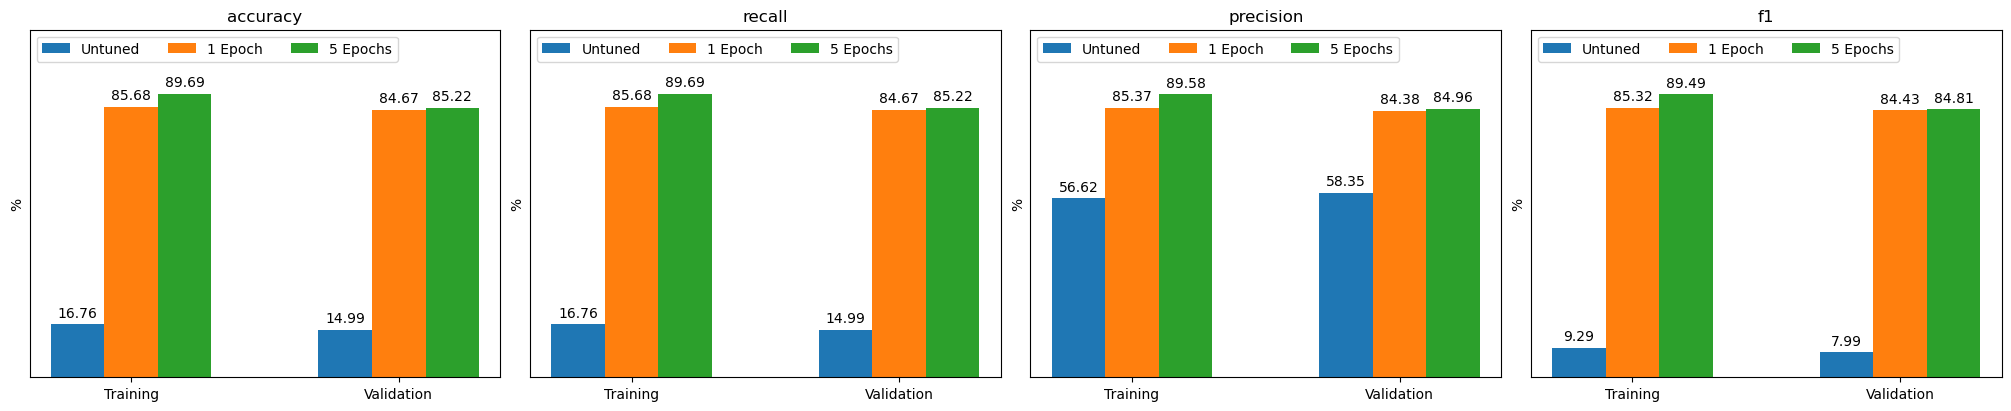

In [87]:
fig, axes = plt.subplots(1, 4, layout='constrained', figsize=(20,4))

for i, ax in enumerate(axes):
    species = ('Training', 'Validation')
    metric = METRICS[i]
    metrics = {
        'Untuned': (model_performance['untuned']['train'][metric]*100,
                    model_performance['untuned']['val'][metric]*100),
        '1 Epoch': (model_performance['tuned']['epochs_1']['train'][metric]*100, 
                    model_performance['tuned']['epochs_1']['val'][metric]*100),
        '5 Epochs': (model_performance['tuned']['epochs_5']['train'][metric]*100, 
                     model_performance['tuned']['epochs_5']['val'][metric]*100)
    }
    
    x = np.arange(len(species))  # the label locations
    width = 0.2  # the width of the bars
    multiplier = 2
    
    for attribute, measurement in metrics.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel('%')
    ax.set_title(metric)
    ax.set_xticks(x + width + 0.4, species)
    ax.set_yticks([])
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 110)
    
plt.show()

# Uploading model to HuggingFace

In [17]:
with open('access_token.txt', 'r') as f:
    access_token = f.read()

login(access_token)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\rosam\.cache\huggingface\token
Login successful


In [18]:
USERNAME = 'gnz5'
MODEL_PATH = 'distilbert-base-uncased-sentiment-analysis'
model_id = f'{USERNAME}/{MODEL_PATH}'

In [19]:
model.push_to_hub(model_id)

README.md:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gnz5/distilbert-base-uncased-sentiment-analysis/commit/765a25644c009b7e1bbb17d7c1fd31526324e027', commit_message='Upload model', commit_description='', oid='765a25644c009b7e1bbb17d7c1fd31526324e027', pr_url=None, pr_revision=None, pr_num=None)

In [20]:
trainer.push_to_hub(model_id)

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gnz5/distilbert-base-uncased-sentiment-analysis/commit/84000b253b6305d1f3245f253d1a6d8dfc93dc31', commit_message='gnz5/distilbert-base-uncased-sentiment-analysis', commit_description='', oid='84000b253b6305d1f3245f253d1a6d8dfc93dc31', pr_url=None, pr_revision=None, pr_num=None)

In [21]:
config = PeftConfig.from_pretrained(model_id)
loaded_model = AutoModelForSequenceClassification.from_pretrained(
    config.base_model_name_or_path, 
    num_labels=len(id2label.keys()), 
    id2label=id2label, 
    label2id=label2id
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(loaded_model, model_id)
model.to(device)

adapter_config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (transformer): Transformer(
          (layer): ModuleList(
            (0-5): 6 x TransformerBlock(
              (attention): MultiHeadSelfAttention(
                (dropout): Dropout(p=0.1, inplace=False)
                (q_lin): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.01, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=76

# References

### Papers:
https://arxiv.org/abs/2309.15223

https://arxiv.org/abs/1910.01108

### APIs:
https://huggingface.co/docs/peft/index

https://huggingface.co/docs/peft/en/package_reference/lora

https://huggingface.co/docs/evaluate/en/base_evaluator